# Synthetic TCSPC data in a cat image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from scipy.stats import norm
from scipy.signal import convolve

from skimage import io
from skimage.measure import label # regionprops_table
from skimage.morphology import remove_small_objects
from skimage.color import label2rgb

from napari_flim_phasor_plotter import _synthetic as syn
import napari

1. Loading the image

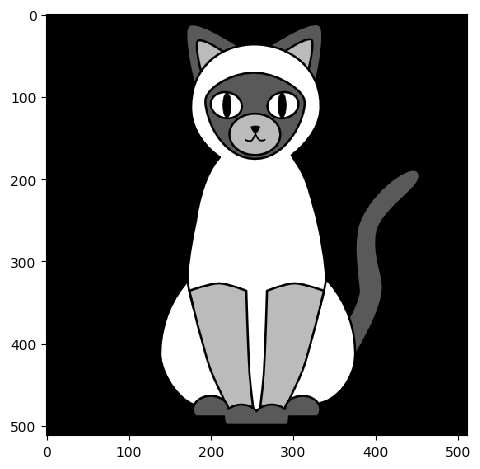

In [3]:
image_path = "/Users/lana/Documents/PoLHiWi2023/Test_data/medium_thick_cat.tiff"

cat_array = io.imread(image_path)
io.imshow(cat_array, cmap=plt.cm.gray)

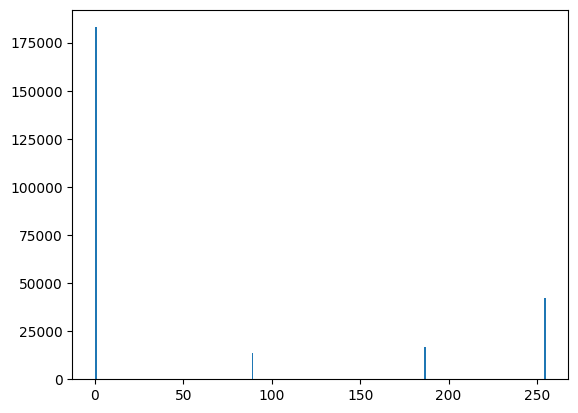

In [4]:
plt.hist(cat_array.ravel(), bins = 256)
plt.show()

Due to some noise in the borders in the png image I divide the image into 4 regions based on the intervals.
* 89 - lifetime tau1
* 187 - mixed lifetimes
* 255 - lifetime tau2
* everything inbetween - background

In [5]:
#copy_cat = 255*np.ones(cat_array.shape, dtype=int)
copy_cat = np.zeros(cat_array.shape, dtype=int)
copy_cat[cat_array  == 89] = 100
copy_cat[cat_array == 187] = 190
copy_cat[cat_array == 255 ] = 255


The I created and visualized masks corresponding to four regions:

In [6]:
white = np.zeros(copy_cat.shape, dtype=bool)
white[copy_cat==255] = True

grey = np.zeros(copy_cat.shape, dtype=bool)
grey[copy_cat==190] = True

dark = np.zeros(copy_cat.shape, dtype=bool)
dark[copy_cat==100] = True

black = np.zeros(copy_cat.shape, dtype=bool)
black[copy_cat==0] = True

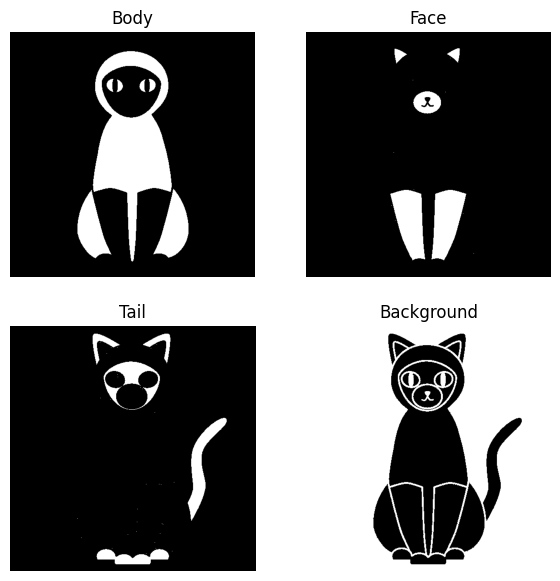

In [7]:
plt.figure(figsize=(7, 7))
plt.subplot(2, 2, 1)
plt.imshow(white, cmap='gray')
plt.title('Body')
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(grey, cmap='gray')
plt.title('Face')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(dark, cmap='gray')
plt.title("Tail")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(black, cmap='gray')
plt.title("Background")
plt.axis("off")

plt.show()


### Generating synthetic lifetime decays

In [8]:
def calculate_exp(x, A, tau):
    import numpy as np
    if np.isscalar(tau):
        tau = np.array([tau])
        A = np.array([A])
    return np.sum(A[:, None] * np.exp(-1/tau[:, None]*x), axis = 0)

In [10]:
def create_synthetic_decay(number_of_output_time_points, amplitudes, life_times, laser_frequency = 40, max_photon_count = 2000, offset = 0, irf_fwhm = 0.1, round_to_int = False):
    #number of time points is the power of 2
    import numpy as np
    from scipy.stats import norm
    from scipy.signal import convolve
    from napari_flim_phasor_plotter import _synthetic as syn

    difference = int(np.rint(10000/number_of_output_time_points))
    number_of_time_points = difference * number_of_output_time_points
    smooth_time = syn.create_time_array(laser_frequency,number_of_time_points)
    smooth_decay = calculate_exp(smooth_time, amplitudes, life_times)
    smooth_irf = norm.pdf(smooth_time, loc = offset, scale = irf_fwhm)
    smooth_irf = smooth_irf[smooth_irf>0]
    smooth_irf /= np.max(smooth_irf)
    smooth_convolved = convolve(smooth_decay, smooth_irf, mode = "full", method = "direct")
    descaled_convolution = np.copy(smooth_convolved[::difference][:number_of_output_time_points])
    descaled_convolution /= np.max(descaled_convolution)
    if round_to_int:
        return(np.rint(descaled_convolution).astype("int"))
    else:
        return(descaled_convolution)
    

In [11]:
tau_1 = 2
tau_2 = 0.8
a1 = 0.6
two_amplitudes = np.array([a1, 1-a1])
tau_array = np.array([tau_1,tau_2])

FWHM of the IRF is usually around 300 ps. IRF can be approximated by a gaussian distribution (some people also use gamma, need to test this one): https://www.frontiersin.org/articles/10.3389/fphy.2021.635645/full

According to Pico Quant meta-data the TCSPC resolution is around 96 ps. FWHM in a gaussian distribution is around 2.35 sigma. Thus I decided on sigma around 100 ps.

In [12]:
laser_frequency = 40 # MHz
number_of_time_points = 256 #common for FLIM images
sigma = 0.1
offset = 0 #3*sigma
time = syn.create_time_array(laser_frequency,number_of_time_points)

In [13]:
conv_counts_tau1 = create_synthetic_decay(number_of_time_points, 1, tau_1, offset = offset, irf_fwhm = sigma)
conv_counts_tau2 = create_synthetic_decay(number_of_time_points, 1, tau_2, offset = offset, irf_fwhm = sigma)
conv_counts_mixed = create_synthetic_decay(number_of_time_points, two_amplitudes, tau_array, offset = offset, irf_fwhm = sigma)

In [14]:
normalized_counts_tau1 = calculate_exp(time, 1, tau_1)
normalized_counts_tau2 = calculate_exp(time, 1, tau_2)
normalized_counts_mixed = calculate_exp(time, two_amplitudes, tau_array)

In [15]:
syn_irf = norm.pdf(time, loc = offset, scale = sigma)
syn_irf /= np.max(syn_irf)

In [16]:
x_end = int(number_of_time_points/2)

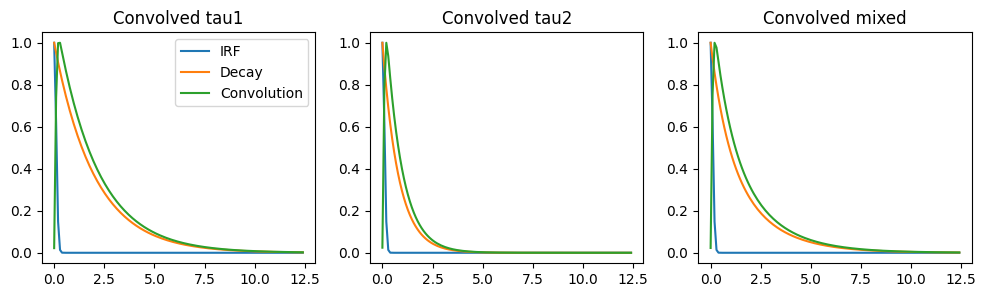

In [17]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(time[:x_end], syn_irf[:x_end], label = "IRF")
plt.plot(time[:x_end], normalized_counts_tau1[:x_end], label = "Decay")
plt.plot(time[:x_end], conv_counts_tau1[:x_end], label = "Convolution")
plt.title('Convolved tau1')
plt.legend(loc = "upper right")


plt.subplot(1, 3, 2)
plt.plot(time[:x_end], syn_irf[:x_end])
plt.plot(time[:x_end], normalized_counts_tau2[:x_end])
plt.plot(time[:x_end], conv_counts_tau2[:x_end])
plt.title('Convolved tau2')


plt.subplot(1, 3, 3)
plt.plot(time[:x_end], syn_irf[:x_end])
plt.plot(time[:x_end], normalized_counts_mixed[:x_end])
plt.plot(time[:x_end], conv_counts_mixed[:x_end])
plt.title("Convolved mixed")

plt.show()

### Testing each create_synthetic_decay function command separately

In [53]:
test_tau = 1
laser_frequency = 40 # MHz
number_of_time_points = 30
sigma = 0.1
offset = 0
descaled_time = syn.create_time_array(laser_frequency,number_of_time_points)

In [54]:
difference = int(np.rint(10000/number_of_time_points))
smooth_time_points = difference * number_of_time_points
smooth_time = syn.create_time_array(laser_frequency, smooth_time_points)

In [56]:
smooth_decay_tau = calculate_exp(smooth_time, 1, test_tau)
smooth_irf = norm.pdf(smooth_time, loc = offset, scale = sigma)
smooth_irf /= np.max(smooth_irf)
smooth_irf = smooth_irf[smooth_irf>0]
smooth_convolved = convolve(smooth_decay_tau, smooth_irf, mode = "full", method = "direct")
descaled_convolution = np.copy(smooth_convolved[::difference][:number_of_time_points])
descaled_convolution /=np.max(descaled_convolution)

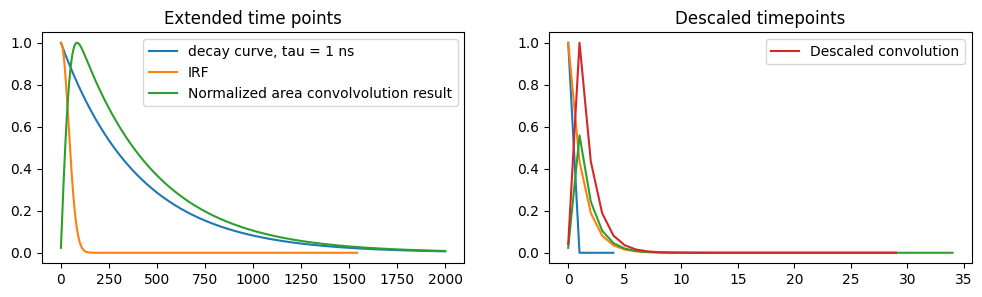

In [57]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(smooth_decay_tau[:2000], label = "decay curve, tau = 1 ns")
plt.plot(smooth_irf[:2000], label = "IRF")
plt.plot((smooth_convolved/np.max(smooth_convolved))[:2000], label = "Normalized area convolvolution result")
plt.title('Extended time points')
plt.legend(loc="upper right")


plt.subplot(1, 2, 2)
plt.plot(smooth_irf[::difference])
plt.plot(smooth_decay_tau[::difference])
plt.plot((smooth_convolved/np.max(smooth_convolved))[::difference])
plt.plot(descaled_convolution, label = "Descaled convolution")
plt.title('Descaled timepoints')
plt.legend(loc="upper right")

plt.show()



### Adding some noise

MATLAB code notes from this paper suggest adding noise after scaling!!!<br>
https://iopscience.iop.org/article/10.1088/2050-6120/aa8055  

``NOTE: After adding noise the simulated decay will have a peak count ``<br>
``%       slightly higher or lower than the defined value. Re-scaling after``<br>
``%       adding noise is not advised, however, as it will skew the noise``<br>
``%       distribution.``

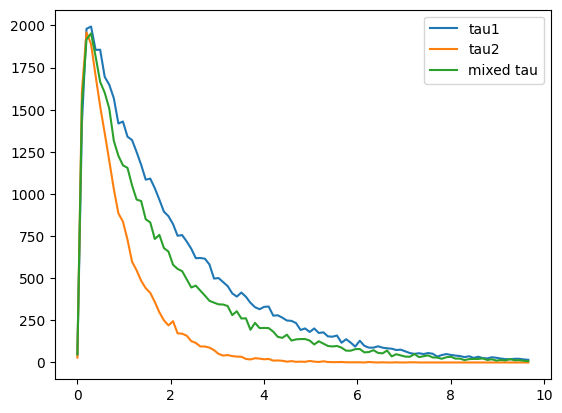

In [18]:
max_number_of_photons = 2000

noisy_tau1 = np.random.poisson(max_number_of_photons * conv_counts_tau1)
noisy_tau2 = np.random.poisson(max_number_of_photons * conv_counts_tau2)
noisy_mixed_tau = np.random.poisson(max_number_of_photons * conv_counts_mixed)

plt.plot(time[:100], noisy_tau1[:100], label = "tau1")
plt.plot(time[:100], noisy_tau2[:100], label = "tau2")
plt.plot(time[:100], noisy_mixed_tau[:100], label = "mixed tau")
plt.legend()
plt.show()


### Assigning life-times to cat masks

In [19]:
def add_lifetime_via_mask(image_size, mask, tcspc_array, max_photon_count = 2000, bg_counts = 0):
    import numpy as np

    processed_image = np.zeros((len(tcspc_array), image_size[0], image_size[1]))
    for x,y in np.transpose(mask.nonzero()):
        processed_image[:,x,y] = np.random.poisson(max_photon_count * tcspc_array) + bg_counts
    
    masked_points = processed_image[:,mask]
    return(masked_points)

very slow function because of the for-loop :c

In [20]:
bg = 50
time_image = bg * np.ones((len(conv_counts_tau1), copy_cat.shape[0], copy_cat.shape[1]))

time_image[:, white] = add_lifetime_via_mask(copy_cat.shape, white, conv_counts_tau1, bg_counts = bg)
time_image[:, grey] = add_lifetime_via_mask(copy_cat.shape, grey, conv_counts_mixed, bg_counts = bg)
time_image[:, dark] = add_lifetime_via_mask(copy_cat.shape, dark, conv_counts_tau2, bg_counts = bg)

In [21]:
viewer = napari.Viewer()

In [22]:
viewer.add_image(time_image)

<Image layer 'time_image' at 0x7fcd4ffdea00>

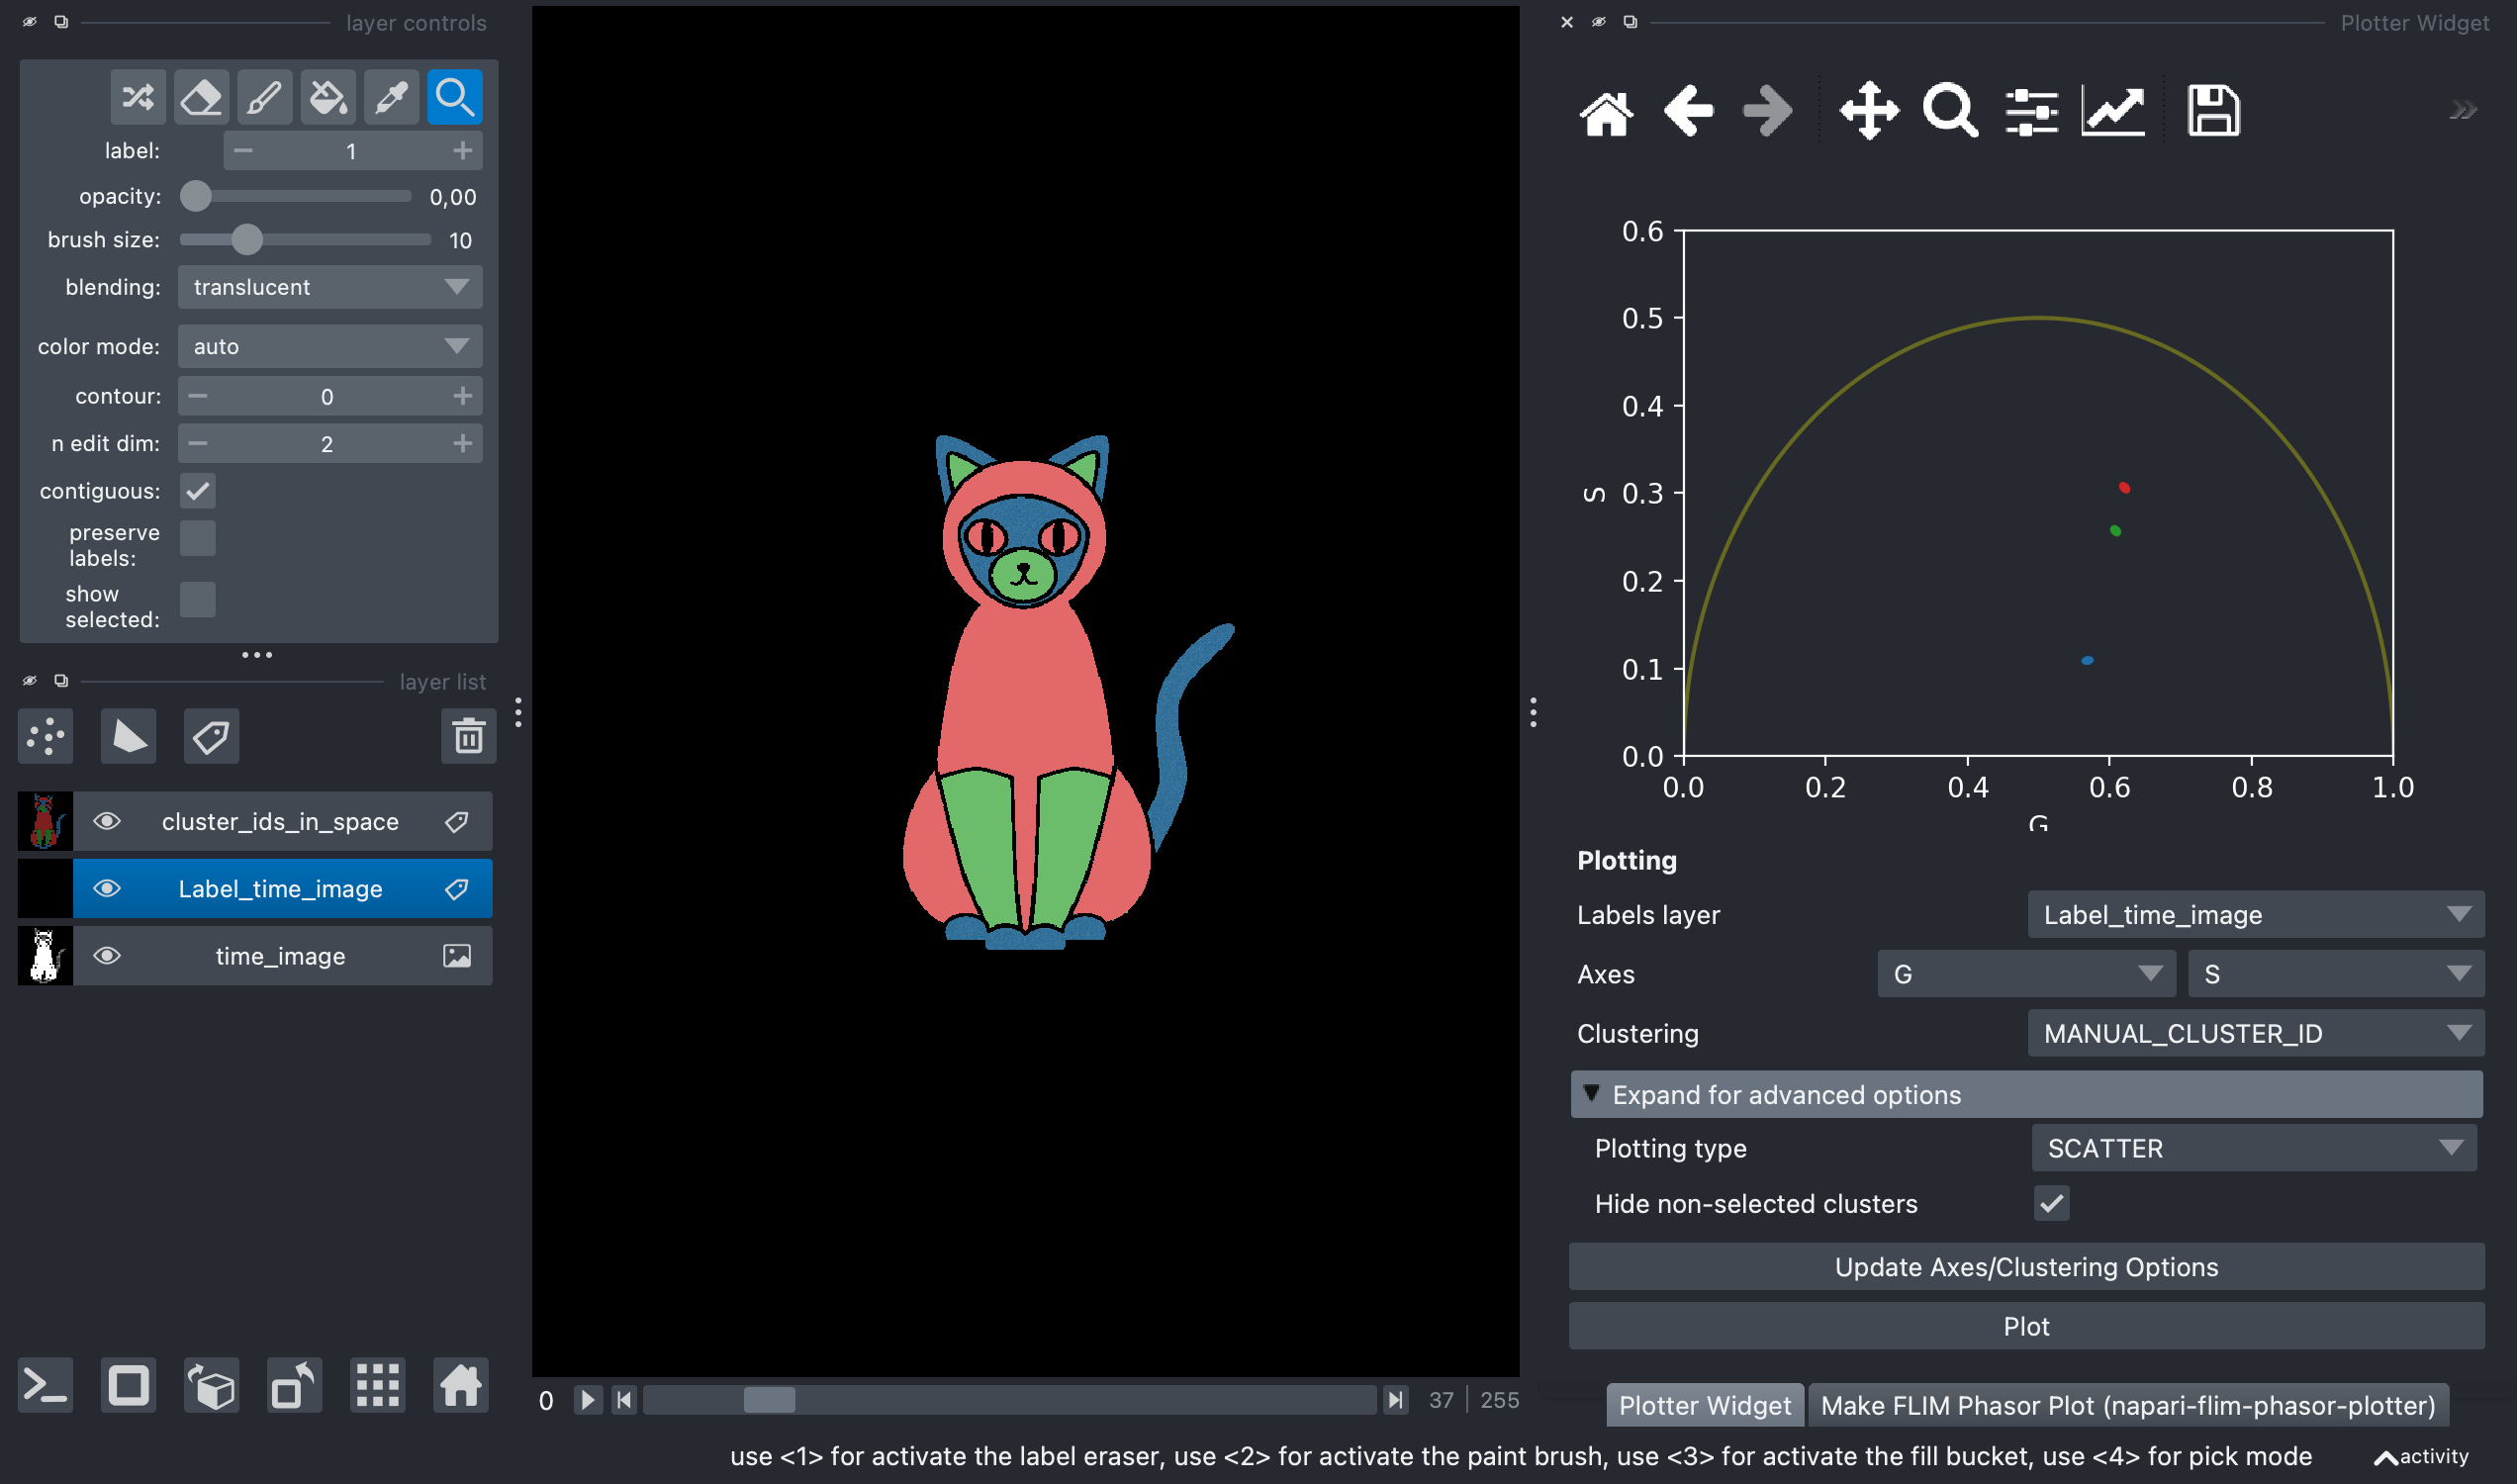

In [24]:
napari.utils.nbscreenshot(viewer)

### Cat labeling

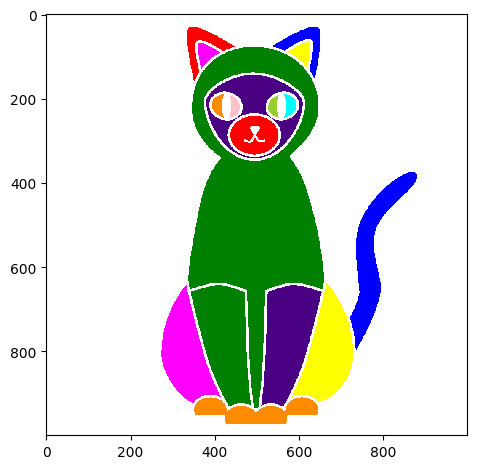

In [8]:
label_cat = label(copy_cat, connectivity=2)
clean_label = remove_small_objects(label_cat, min_size=200)

segmented_image = label2rgb(clean_label, bg_label=0, bg_color = "white")
io.imshow(segmented_image )

In [9]:
len(np.unique(label_cat)), len(np.unique(clean_label))

(108, 18)

In [10]:
viewer = napari.Viewer()

In [11]:
viewer.add_image(copy_cat)
viewer.add_labels(label_cat)
viewer.add_labels(clean_label)

<Labels layer 'clean_label' at 0x7f8bc78f2d90>

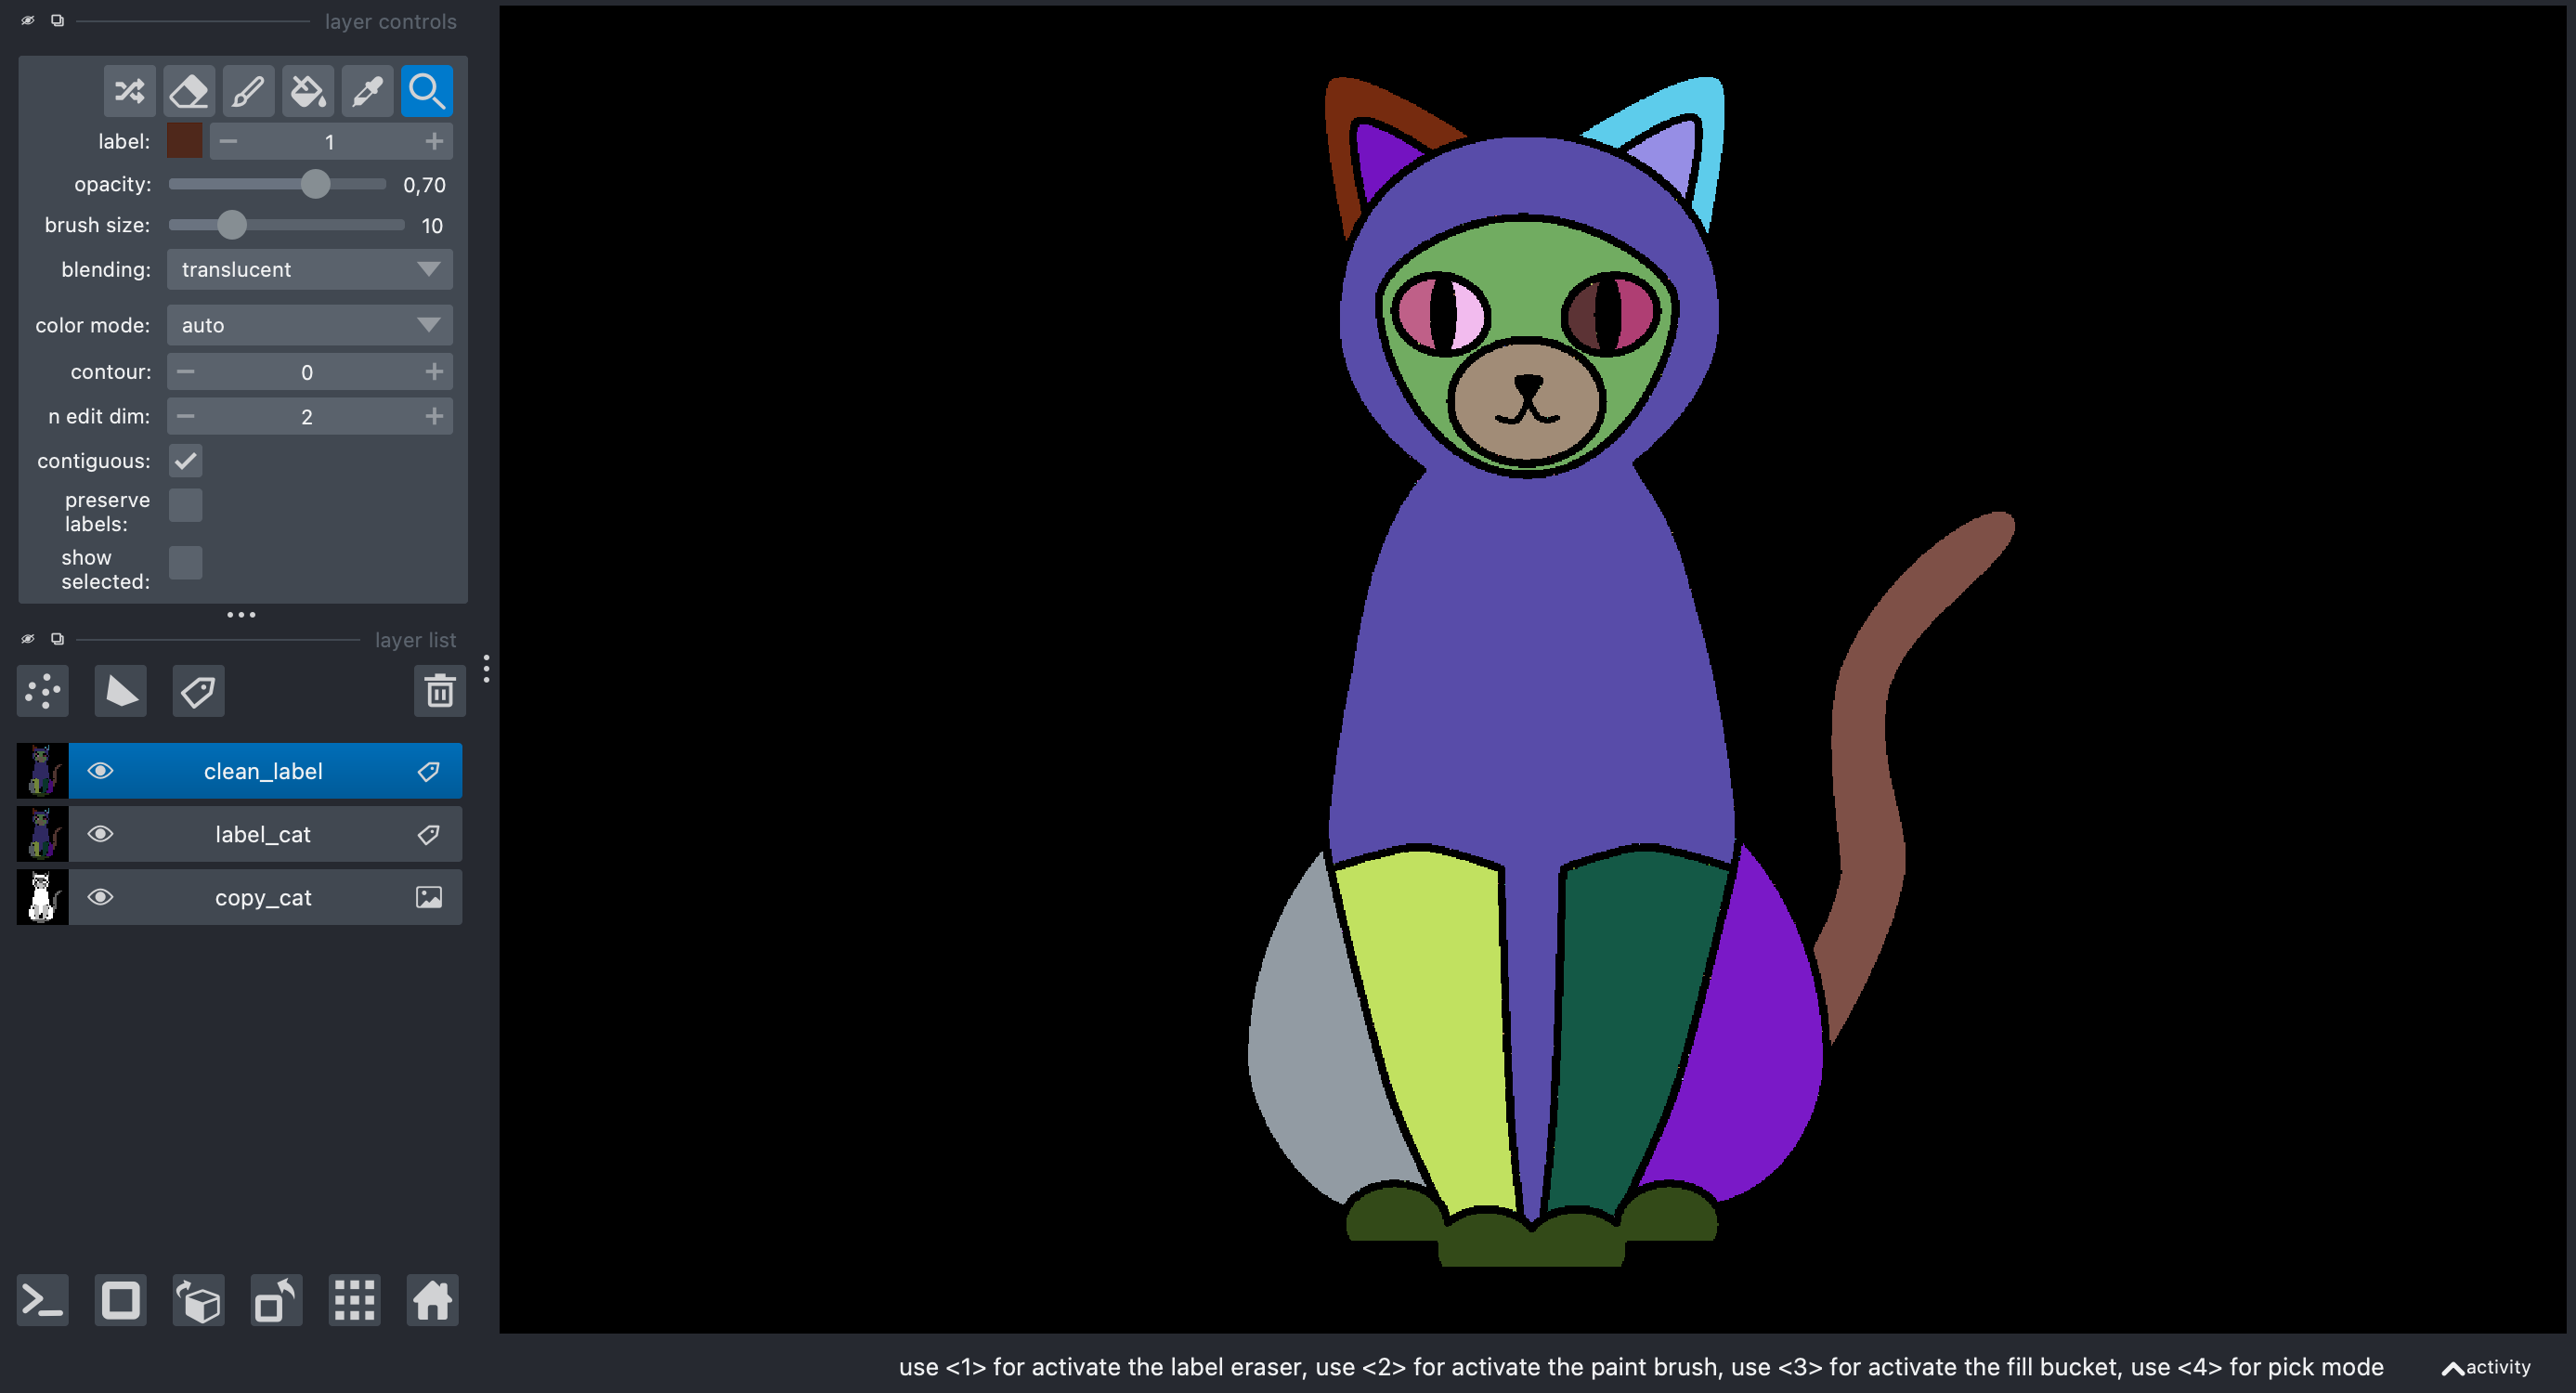

In [12]:
napari.utils.nbscreenshot(viewer)